In [1]:
from surprise import Reader, Dataset, KNNBasic
from surprise import accuracy
import pandas as pd
from surprise import SVD, SlopeOne, SVDpp
from surprise import accuracy
import numpy as np

In [2]:
read = pd.read_pickle('../Pickle/read.pkl')

In [3]:
users_with_only_zeros = read.groupby('user_id')['rating'].apply(lambda x: (x == 0).all())
users_with_only_zeros = users_with_only_zeros[users_with_only_zeros].index
read = read[~read['user_id'].isin(users_with_only_zeros)]

In [4]:
read = read[read['is_read'] != 0]
unrated = read[read['rating'] == 0]
read = read[read['rating'] != 0]
unrated = unrated.reset_index(drop = True)
read = read.reset_index(drop = True)

In [5]:
read = read.sample(frac=0.1, random_state = 42)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data_with_single_interactions(read):
    # Identify users and books that appear only once in the dataset
    user_counts = read['user_id'].value_counts()
    book_counts = read['book_id'].value_counts()

    # Find interactions where user or book appears only once
    single_interactions = read[
        read['user_id'].isin(user_counts[user_counts == 1].index) | 
        read['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    # Remove those interactions from the main dataset
    remaining_interactions = read[~read.index.isin(single_interactions.index)]

    # Split the remaining interactions into train and test using sklearn's train_test_split
    train_df, test_df = train_test_split(remaining_interactions, test_size=0.2, random_state=42)

    # Add the single interactions to the training set
    train_df = pd.concat([train_df, single_interactions], ignore_index=True)

    # # Ensure the split maintains the 80/20 ratio
    # train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the train set
    # test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the test set

    return train_df, test_df

train_df, test_df = split_data_with_single_interactions(read)

In [7]:
# Get rating counts
rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
majority_count = rating_counts.max()

# Dictionary to store modified dataframes
modified_dfs = []

# Perform upsampling with slight noise addition for each class
for rating, count in rating_counts.items():
    class_df = train_df[train_df['rating'] == rating]
    
    # Duplicate rows based on the majority class size, ensuring the size of the class is adjusted
    num_duplicates = int(majority_count / count)  # Number of duplications required
    
    # Duplicate the class_df rows and add small random noise to the ratings
    duplicated_df = pd.concat([class_df] * num_duplicates, ignore_index=True)
    
    # Add random noise to the ratings
    duplicated_df['rating'] = duplicated_df['rating'] + np.random.uniform(-0.1, 0.1, size=duplicated_df.shape[0])
    
    # Ensure ratings are within the valid range (e.g., between 1 and 5)
    duplicated_df['rating'] = duplicated_df['rating'].clip(1, 5)
    
    modified_dfs.append(duplicated_df)

# Combine all modified data
balanced_train = pd.concat(modified_dfs)

# Shuffle dataset
train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
# Log scale ratings
def normalise_ratings(train_data, test_data):
    min_rating = train_data['rating'].min()
    
    if min_rating < 0:
        train_data['rating'] = train_data['rating'] - min_rating
        test_data['rating'] = test_data['rating'] - min_rating

    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])

    return train_data, test_data, min_rating

def denormalize_rating(log_scaled_ratings, min_rating=0):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)  # Ensure NumPy array

    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)

    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating

    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)


train_df, test_df, min_rating = normalise_ratings(train_df, test_df)

In [9]:
# Reduce memory usage by converting IDs to smaller data types
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['book_id'] = train_df['book_id'].astype('str')
train_df['rating'] = train_df['rating'].astype('float32')

test_df['user_id'] = test_df['user_id'].astype('str')
test_df['book_id'] = test_df['book_id'].astype('str')
test_df['rating'] = test_df['rating'].astype('float32')

# Define the reader with rating scale
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))

# Create trainset
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset = train_data.build_full_trainset()

# Create testset properly using test_df_sample
test_data = Dataset.load_from_df(test_df[['user_id', 'book_id', 'rating']], reader)
testset = test_data.build_full_trainset().build_testset()  # Correct way to build testset

In [ ]:
svd = SVD()
svd.fit(trainset)

RMSE: 0.2475
MAE:  0.1884


In [55]:
predictions_svd = svd.test(testset)
rmse = accuracy.rmse(predictions_svd)
mae = accuracy.mae(predictions_svd)

RMSE: 0.2475
MAE:  0.1884


In [58]:
from collections import defaultdict
from math import log2
# Evaluation metrics: Precision, Recall, and nDCG at k
def precision_recall_ndcg_at_k(predictions, k, threshold):
    """Return precision, recall, and nDCG at k metrics for each user."""
    
    def dcg_at_k(scores, k):
        return sum([rel / log2(idx + 2) for idx, rel in enumerate(scores[:k])])

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    ndcgs = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        
        # nDCG@K
        actual = [true_r for (_, true_r) in user_ratings]
        ideal = sorted(actual, reverse=True)
        
        idcg = dcg_at_k(ideal, k)
        dcg = dcg_at_k([rel for (est, rel) in user_ratings], k)
        ndcgs[uid] = dcg / idcg if idcg > 0 else 0
    
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    ndcg = sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)
    
    return precision, recall, ndcg

# Compute the evaluation metrics
precision, recall, ndcg = precision_recall_ndcg_at_k(predictions_svd, k=5, threshold=5)
print(f'Adjusted Precision: {precision}, Adjusted Recall: {recall}, Adjusted nDCG: {ndcg}')

Adjusted Precision: 1.0, Adjusted Recall: 1.0, Adjusted nDCG: 0.97923830750611


In [42]:
est_ratings_svd = np.array([pred.est for pred in predictions_svd], dtype=float)

In [43]:
predictions_svd = denormalize_rating(est_ratings_svd)

In [49]:
predictions_svd

array([3.08821212, 4.09088296, 4.94946095, ..., 3.96284614, 3.6129204 ,
       3.63501441])

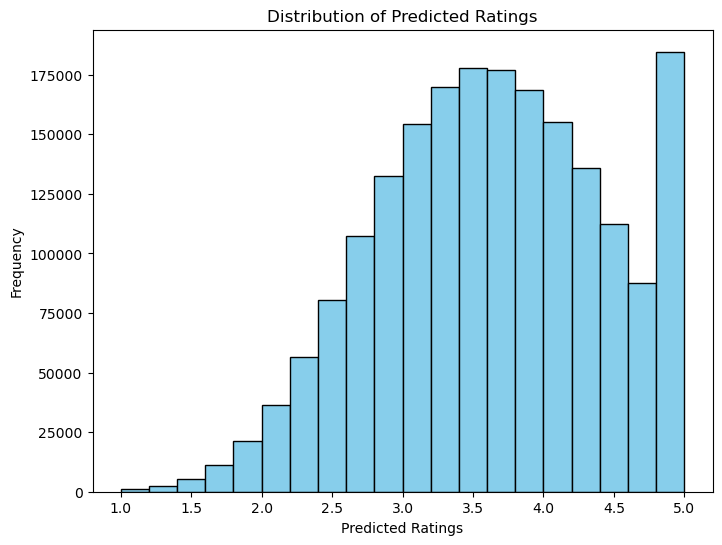

In [44]:
import matplotlib.pyplot as plt

def plot_prediction_histogram(predictions):
    plt.figure(figsize=(8, 6))
    plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Ratings')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_histogram(predictions_svd)

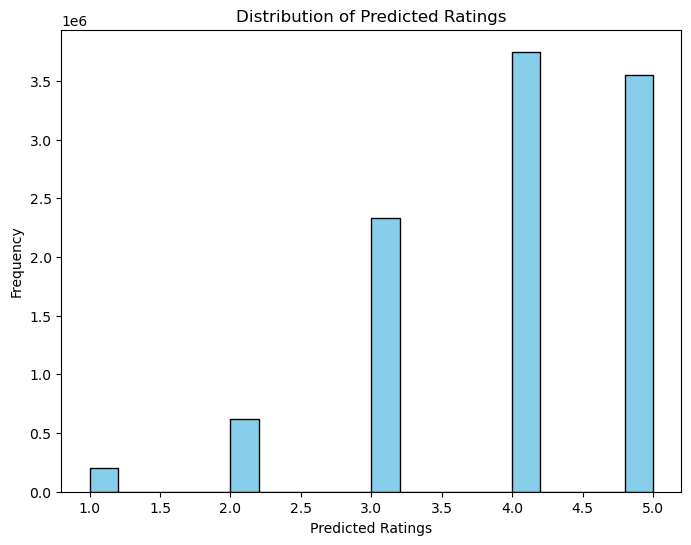

In [45]:
import matplotlib.pyplot as plt

def plot_prediction_histogram(predictions):
    plt.figure(figsize=(8, 6))
    plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Ratings')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_histogram(read['rating'])

In [46]:
predictions_svd.mean()

3.6315595858129113

In [47]:
read['rating'].mean()

3.9394919539691187

In [53]:
y_true = test_df['rating']
y_true = denormalize_rating(y_true)

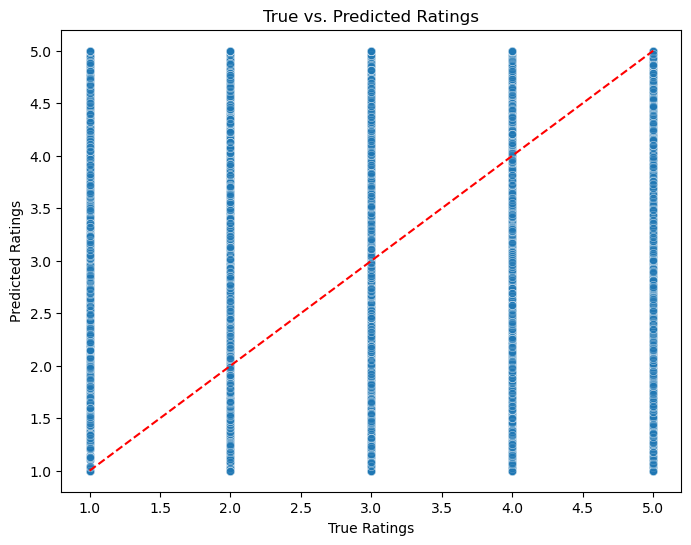

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `y_true` contains the true ratings and `y_pred` contains the predicted ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=predictions_svd, alpha=0.5)
plt.xlabel("True Ratings")
plt.ylabel("Predicted Ratings")
plt.title("True vs. Predicted Ratings")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')  # Diagonal line

plt.show()